# Tutorial for bulk Monte Carlo calculations in the structural-color package

In [1]:
%matplotlib inline
import numpy as np
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import phase_func_sphere as pfs
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())

/home/stephenson/Repositories/structural-color


### Set parameters

In [2]:
# Properties of system
ntrajectories = 20000         # number of trajectories for one microsphere
nevents = 500                 # number of scattering events in each trajectory in a microsphere
ntrajectories_bulk = 50000    # number of trajectories to run in the bulk film
nevents_bulk = 500            # number of events to run in the bulk film
wavelengths = sc.Quantity(np.arange(400., 801.,10),'nm') # wavelengths at which to calculate reflectance
microsphere_radius = sc.Quantity(10,'um')  # radius of the microsphere
nanosphere_radius = sc.Quantity('0.125 um') # radius of the nanosphere
volume_fraction_microspheres = sc.Quantity(0.55,'') # volume fraction of the microspheres packed in a a nanosphere
volume_fraction_nanospheres = sc.Quantity(0.55, '') # volume fraction of the nanospheres packed in a microsphere
bulk_thickness = sc.Quantity('300 um') # thickness of the bulk film

# refractive indices
n_nanoparticle = ri.n('vacuum', wavelengths) # refractive index of nanoparticle
n_matrix = ri.n('fused silica', wavelengths) # refractive index of matrix
n_medium = ri.n('vacuum', wavelengths) # refractive index of medium outside the sample. 
n_matrix_bulk = n_medium
n_medium_bulk = ri.n('vacuum', wavelengths)

# Properties that should not need to be changed
z_low = sc.Quantity('0.0 um') # sets trajectories starting point
sns.set_style('white') # sets white plotting background

### Run Monte Carlo for sphere geometry and calculate phase function

In [3]:
theta = np.linspace(.01,np.pi,200)
nu = (np.cos(theta)+1)/2
p_microsphere = np.zeros((wavelengths.size, 200))
reflectance_microsphere = np.zeros(wavelengths.size)
lscat = sc.Quantity(np.zeros(wavelengths.size),'um')

for i in range(wavelengths.size):
    # print wavlengths to keep track of where we are in calculation
    print('wavelength: ' + str(wavelengths[i]))
    
    # caculate the effective index of the sample
    n_sample = ri.n_eff(n_nanoparticle[i], n_matrix[i], volume_fraction_nanospheres)
    
    # Calculate the phase function and scattering and absorption coefficients from the single scattering model
    # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
    p, mu_scat, mu_abs = mc.calc_scat(nanosphere_radius, n_nanoparticle[i], n_sample,
                                      volume_fraction_nanospheres, wavelengths[i])

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_medium[i], n_sample, microsphere_radius)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')

    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)

    # Calculate reflection and transmition 
    (refl_indices, trans_indices, 
    k1_refl, k1_trans, 
    norm_refl, norm_trans,
    refl_per_traj, trans_per_traj,
    reflectance_microsphere[i], transmittance_microsphere)\
             = mc.calc_refl_trans_sphere(trajectories, n_medium[i], n_sample, microsphere_radius, 
                                         p, mu_abs, mu_scat, plot_exits = False, run_tir = False, return_extra = True)
    
    # calculate the lscat of the microsphere for use in the bulk simulation
    lscat[i] = pfs.calc_lscat(refl_per_traj, trans_per_traj, trans_indices, volume_fraction_nanospheres, microsphere_radius)
    
    # find the points on the sphere where trajectories exit
    x_inter, y_inter, z_inter = pfs.get_exit_pos(norm_refl, norm_trans, microsphere_radius)
    
    # calculate the probability density function as a function of nu, which depends on the scattering angle
    pdf = pfs.calc_pdf(x_inter, y_inter, z_inter, microsphere_radius, plot = False, phi_dependent = False)

    # calculate the probability density function values for the nu values of interest and store for each wavelength
    p_microsphere[i,:] = pdf(nu)

wavelength: 400.0 nanometer


/home/stephenson/anaconda3/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:912: RuntimeWarning: invalid value encountered in greater
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: divide by zero encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:606: RuntimeWarning: invalid value encountered in true_divide
  k1 = k1/mag
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:628: RuntimeWarning: invalid value encountered in true_divide
  dot_z = np.nan_to_num(abs(select_z1-select_z0)/mag)


wavelength: 410.0 nanometer
wavelength: 420.0 nanometer
wavelength: 430.0 nanometer
wavelength: 440.0 nanometer
wavelength: 450.0 nanometer
wavelength: 460.0 nanometer
wavelength: 470.0 nanometer
wavelength: 480.0 nanometer
wavelength: 490.0 nanometer
wavelength: 500.0 nanometer
wavelength: 510.0 nanometer
wavelength: 520.0 nanometer
wavelength: 530.0 nanometer
wavelength: 540.0 nanometer
wavelength: 550.0 nanometer
wavelength: 560.0 nanometer
wavelength: 570.0 nanometer
wavelength: 580.0 nanometer
wavelength: 590.0 nanometer
wavelength: 600.0 nanometer
wavelength: 610.0 nanometer
wavelength: 620.0 nanometer
wavelength: 630.0 nanometer
wavelength: 640.0 nanometer
wavelength: 650.0 nanometer
wavelength: 660.0 nanometer
wavelength: 670.0 nanometer
wavelength: 680.0 nanometer
wavelength: 690.0 nanometer
wavelength: 700.0 nanometer
wavelength: 710.0 nanometer
wavelength: 720.0 nanometer
wavelength: 730.0 nanometer
wavelength: 740.0 nanometer
wavelength: 750.0 nanometer
wavelength: 760.0 na

#### Plot results

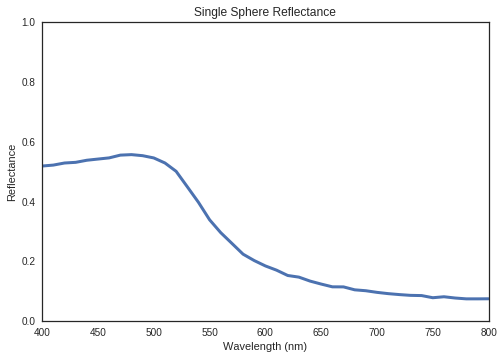

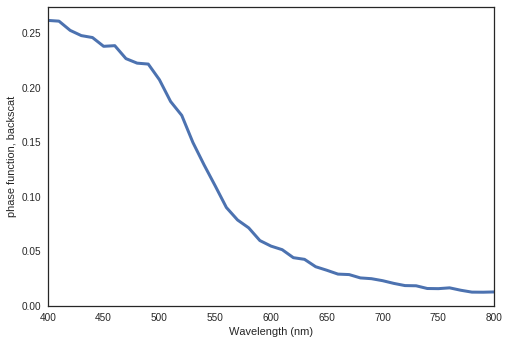

In [4]:
plt.figure()
plt.plot(wavelengths, reflectance_microsphere, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Single Sphere Reflectance')
#plt.savefig('reflectance_1sphere.pdf')

plt.figure()
plt.plot(wavelengths, p_microsphere[:,100], linewidth = 3)
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('phase function, backscat')

### Calculate reflectance for bulk film of structurally colored microspheres

There are two key differences between the bulk Monte Carlo simulation and a typical Monte Carlo simulation

1. Trajectory 1st step direction
In the bulk film, trajectories do not propagate forward one step before scattering. Instead they enter the sample at an angle sampled from the the structured sphere phase function. We chose not to propagate them forward by 1 step first because the 1 step forward propagation is already accounted for in the monte carlo run inside the structured sphere.  

2. Scattering length
In the bulk film, the scattering length is not sampled from a distribution, but is instead is assumed to be the interparticle spacing calculated from the diameter and volume fraction of the structured spheres.
It is unclear whether this is the ideal scattering length to use, so this may be updated in future versions.


In [5]:
reflectance_bulk = np.zeros(wavelengths.size)
for i in range(wavelengths.size):
    
    # print the wavelength keep track of where we are in calculation 
    print('wavelength: ' + str(wavelengths[i]))

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents_bulk, ntrajectories_bulk, n_medium_bulk[i], n_matrix_bulk[i])
    r0 = sc.Quantity(r0, 'um')
    W0 = sc.Quantity(W0, '')

    # Sample angles
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents_bulk, ntrajectories_bulk, 
                                                                p_microsphere[i,:])

    # Calculate step size
    d_avg = pfs.calc_d_avg(volume_fraction_microspheres, microsphere_radius)
    step = d_avg*np.ones((nevents_bulk,ntrajectories_bulk))
    step = lscat[i]*np.ones((nevents_bulk,ntrajectories_bulk))

    # initialize first direction to be the last sampled angle 
    # (since last sample angle isn't used, this is equivalent to sampling another angle)
    k0[0,0,:] = sintheta[-1,:]*cosphi[-1,:]
    k0[1,0,:] = sintheta[-1,:]*sinphi[-1,:]
    k0[2,0,:] = costheta[-1,:]
    k0 = sc.Quantity(k0, '')
    
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    #trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)

    # calculate reflectance
    reflectance_bulk[i], transmittance = mc.calc_refl_trans(trajectories, z_low, bulk_thickness, 
                                                               n_medium_bulk[i], n_matrix_bulk[i])

wavelength: 400.0 nanometer
wavelength: 410.0 nanometer
wavelength: 420.0 nanometer
wavelength: 430.0 nanometer
wavelength: 440.0 nanometer
wavelength: 450.0 nanometer
wavelength: 460.0 nanometer
wavelength: 470.0 nanometer
wavelength: 480.0 nanometer
wavelength: 490.0 nanometer
wavelength: 500.0 nanometer
wavelength: 510.0 nanometer
wavelength: 520.0 nanometer
wavelength: 530.0 nanometer
wavelength: 540.0 nanometer
wavelength: 550.0 nanometer
wavelength: 560.0 nanometer
wavelength: 570.0 nanometer
wavelength: 580.0 nanometer
wavelength: 590.0 nanometer
wavelength: 600.0 nanometer
wavelength: 610.0 nanometer
wavelength: 620.0 nanometer
wavelength: 630.0 nanometer
wavelength: 640.0 nanometer
wavelength: 650.0 nanometer
wavelength: 660.0 nanometer
wavelength: 670.0 nanometer
wavelength: 680.0 nanometer
wavelength: 690.0 nanometer
wavelength: 700.0 nanometer
wavelength: 710.0 nanometer
wavelength: 720.0 nanometer
wavelength: 730.0 nanometer
wavelength: 740.0 nanometer
wavelength: 750.0 na

#### Plot results

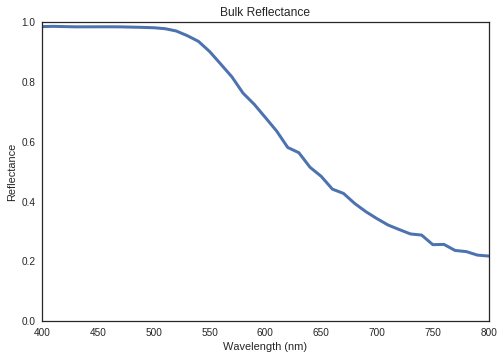

In [6]:
plt.figure()
plt.plot(wavelengths, reflectance_bulk, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Bulk Reflectance')
#plt.savefig('reflectance_bulk.pdf')